## 期末大作业：UCI Wine Quality 数据集的分类预测

### 一、数据集介绍

本大作业所用数据集为 **UCI Wine Quality Dataset**，来源于葡萄牙的 "Vinho Verde" 红酒样本。数据集共有1599个观测样本，每个样本包含11个物理化学特征及一个质量评分（从0到10分），其中质量评分表示了专家对该红酒的品质评价。

数据集中包含的11个特征分别是：

* fixed acidity（固定酸度）
* volatile acidity（挥发性酸度）
* citric acid（柠檬酸含量）
* residual sugar（残糖量）
* chlorides（氯化物含量）
* free sulfur dioxide（游离二氧化硫）
* total sulfur dioxide（总二氧化硫）
* density（密度）
* pH（酸碱度）
* sulphates（硫酸盐含量）
* alcohol（酒精含量）

质量评分（quality）为整数，范围为0-10。本次作业需要你将此数据集用于分类问题。

### 二、作业要求

#### 1. 数据预处理

* 检查是否存在缺失值。
* 将数据划分为训练集（70%）和测试集（30%）。

#### 2. 建模与预测

分别使用以下三种分类方法构建分类预测模型：

**（1）随机森林（Random Forest）**

* 使用scikit-learn的`RandomForestClassifier`。
* 明确说明你选择的树的数量和其他超参数。

**（2）神经网络（Neural Network）**

* 使用TensorFlow搭建一个简单的神经网络。
* 包含两个隐藏层，写明各层的神经元数量、激活函数、损失函数、优化器等参数设置。

**（3）支持向量机（Support Vector Machine, SVM）**

* 使用scikit-learn的`SVC`实现。
* 尝试线性、高斯和多项式三种核函数。

#### 3. 模型评价

* 使用准确率（accuracy）、精确率（precision）、召回率（recall）、F1-score等指标分别评价三个模型。
* 通过混淆矩阵展示分类效果。

#### 4. 模型比较

* 比较三种方法在测试集上的表现，讨论哪种方法在本问题上表现最好，并分析可能原因。

### 三、提交要求

* 作业以Jupyter Notebook文件（`.ipynb`）提交，在文件名写明自己的姓名学号。
* Notebook内需要清晰展示代码、结果和详细分析。
* 在结尾处，给出你的总结与反思，说明对模型的理解、性能差异的分析及未来可能的改进方向。

**截止日期：** 请于6月13日23:59pm之前提交至助教邮箱



In [1]:
# 预下载调参工具
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple optuna

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [2]:
# 特征工程包
!pip install autofeat

In [3]:
#tensorflow不支持python3.12，安装pytorch
!pip install -i https://pypi.tuna.tsinghua.edu.cn/simple torch torchvision torchaudio

Looking in indexes: https://pypi.tuna.tsinghua.edu.cn/simple


In [4]:
import torch
print(torch.__version__)
print(torch.cuda.is_available())

2.7.0+cpu
False


In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import PowerTransformer
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import optuna
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, classification_report

In [6]:
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, TensorDataset

In [7]:
url = "https://archive.ics.uci.edu/ml/machine-learning-databases/wine-quality/winequality-red.csv"
wine_data = pd.read_csv(url, sep=';')
print(wine_data.head())

   fixed acidity  volatile acidity  citric acid  residual sugar  chlorides  \
0            7.4              0.70         0.00             1.9      0.076   
1            7.8              0.88         0.00             2.6      0.098   
2            7.8              0.76         0.04             2.3      0.092   
3           11.2              0.28         0.56             1.9      0.075   
4            7.4              0.70         0.00             1.9      0.076   

   free sulfur dioxide  total sulfur dioxide  density    pH  sulphates  \
0                 11.0                  34.0   0.9978  3.51       0.56   
1                 25.0                  67.0   0.9968  3.20       0.68   
2                 15.0                  54.0   0.9970  3.26       0.65   
3                 17.0                  60.0   0.9980  3.16       0.58   
4                 11.0                  34.0   0.9978  3.51       0.56   

   alcohol  quality  
0      9.4        5  
1      9.8        5  
2      9.8        5 

#### 1.数据预处理

In [8]:
# 检测缺失值，不存在缺失值
wine_data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1599 entries, 0 to 1598
Data columns (total 12 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   fixed acidity         1599 non-null   float64
 1   volatile acidity      1599 non-null   float64
 2   citric acid           1599 non-null   float64
 3   residual sugar        1599 non-null   float64
 4   chlorides             1599 non-null   float64
 5   free sulfur dioxide   1599 non-null   float64
 6   total sulfur dioxide  1599 non-null   float64
 7   density               1599 non-null   float64
 8   pH                    1599 non-null   float64
 9   sulphates             1599 non-null   float64
 10  alcohol               1599 non-null   float64
 11  quality               1599 non-null   int64  
dtypes: float64(11), int64(1)
memory usage: 150.0 KB


In [9]:
# 检测离群值，不存在明显离群值
wine_data.describe()

fixed acidity  volatile acidity  citric acid  residual sugar  \
count    1599.000000       1599.000000  1599.000000     1599.000000   
mean        8.319637          0.527821     0.270976        2.538806   
std         1.741096          0.179060     0.194801        1.409928   
min         4.600000          0.120000     0.000000        0.900000   
25%         7.100000          0.390000     0.090000        1.900000   
50%         7.900000          0.520000     0.260000        2.200000   
75%         9.200000          0.640000     0.420000        2.600000   
max        15.900000          1.580000     1.000000       15.500000   

         chlorides  free sulfur dioxide  total sulfur dioxide      density  \
count  1599.000000          1599.000000           1599.000000  1599.000000   
mean      0.087467            15.874922             46.467792     0.996747   
std       0.047065            10.460157             32.895324     0.001887   
min       0.012000             1.000000              6.000000     0.990070   
25%       0.070000             7.000000             22.000000     0.995600   
50%       0.079000            14.000000             38.000000     0.996750   
75%       0.090000            21.000000             62.000000     0.997835   
max       0.611000            72.000000            289.000000     1.003690   

                pH    sulphates      alcohol      quality  
count  1599.000000  1599.000000  1599.000000  1599.000000  
mean      3.311113     0.658149    10.422983     5.636023  
std       0.154386     0.169507     1.065668     0.807569  
min       2.740000     0.330000     8.400000     3.000000  
25%       3.210000     0.550000     9.500000     5.000000  
50%       3.310000     0.620000    10.200000     6.000000  
75%       3.400000     0.730000    11.100000     6.000000  
max       4.010000     2.000000    14.900000     8.000000

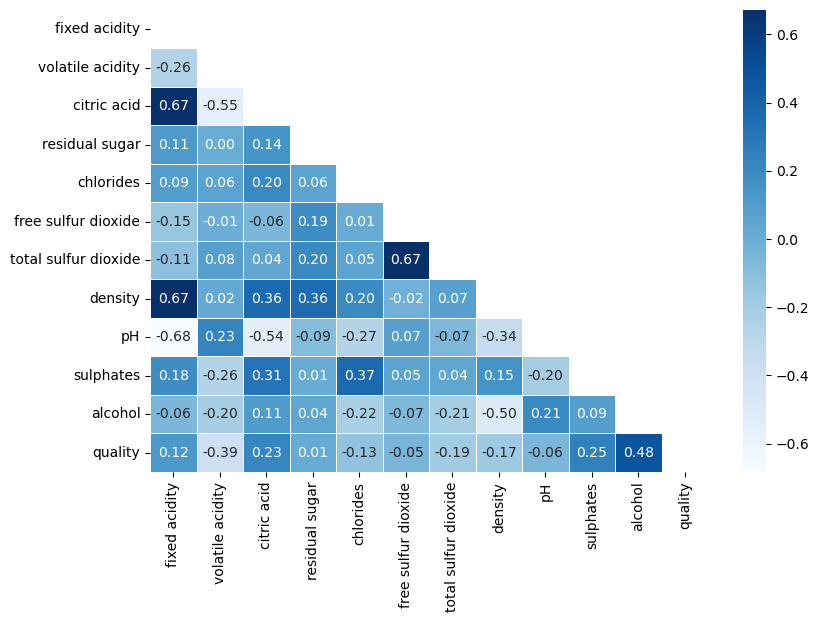

In [10]:
# 观察数据特征
corr = wine_data.corr()
plt.figure(figsize=(9, 6))
sns.heatmap(corr, annot=True, fmt='.2f', linewidth=0.5, cmap='Blues', mask=np.triu(corr))
plt.show()

In [11]:
# corr=0.67这三个，用他们的比例构建特征
wine_data['Feature1'] = wine_data['citric acid']/wine_data['fixed acidity']
wine_data['Feature2'] = wine_data['density']/wine_data['fixed acidity']
wine_data['Feature3'] = wine_data['total sulfur dioxide']/wine_data['free sulfur dioxide']

<Figure size 1800x1200 with 0 Axes>

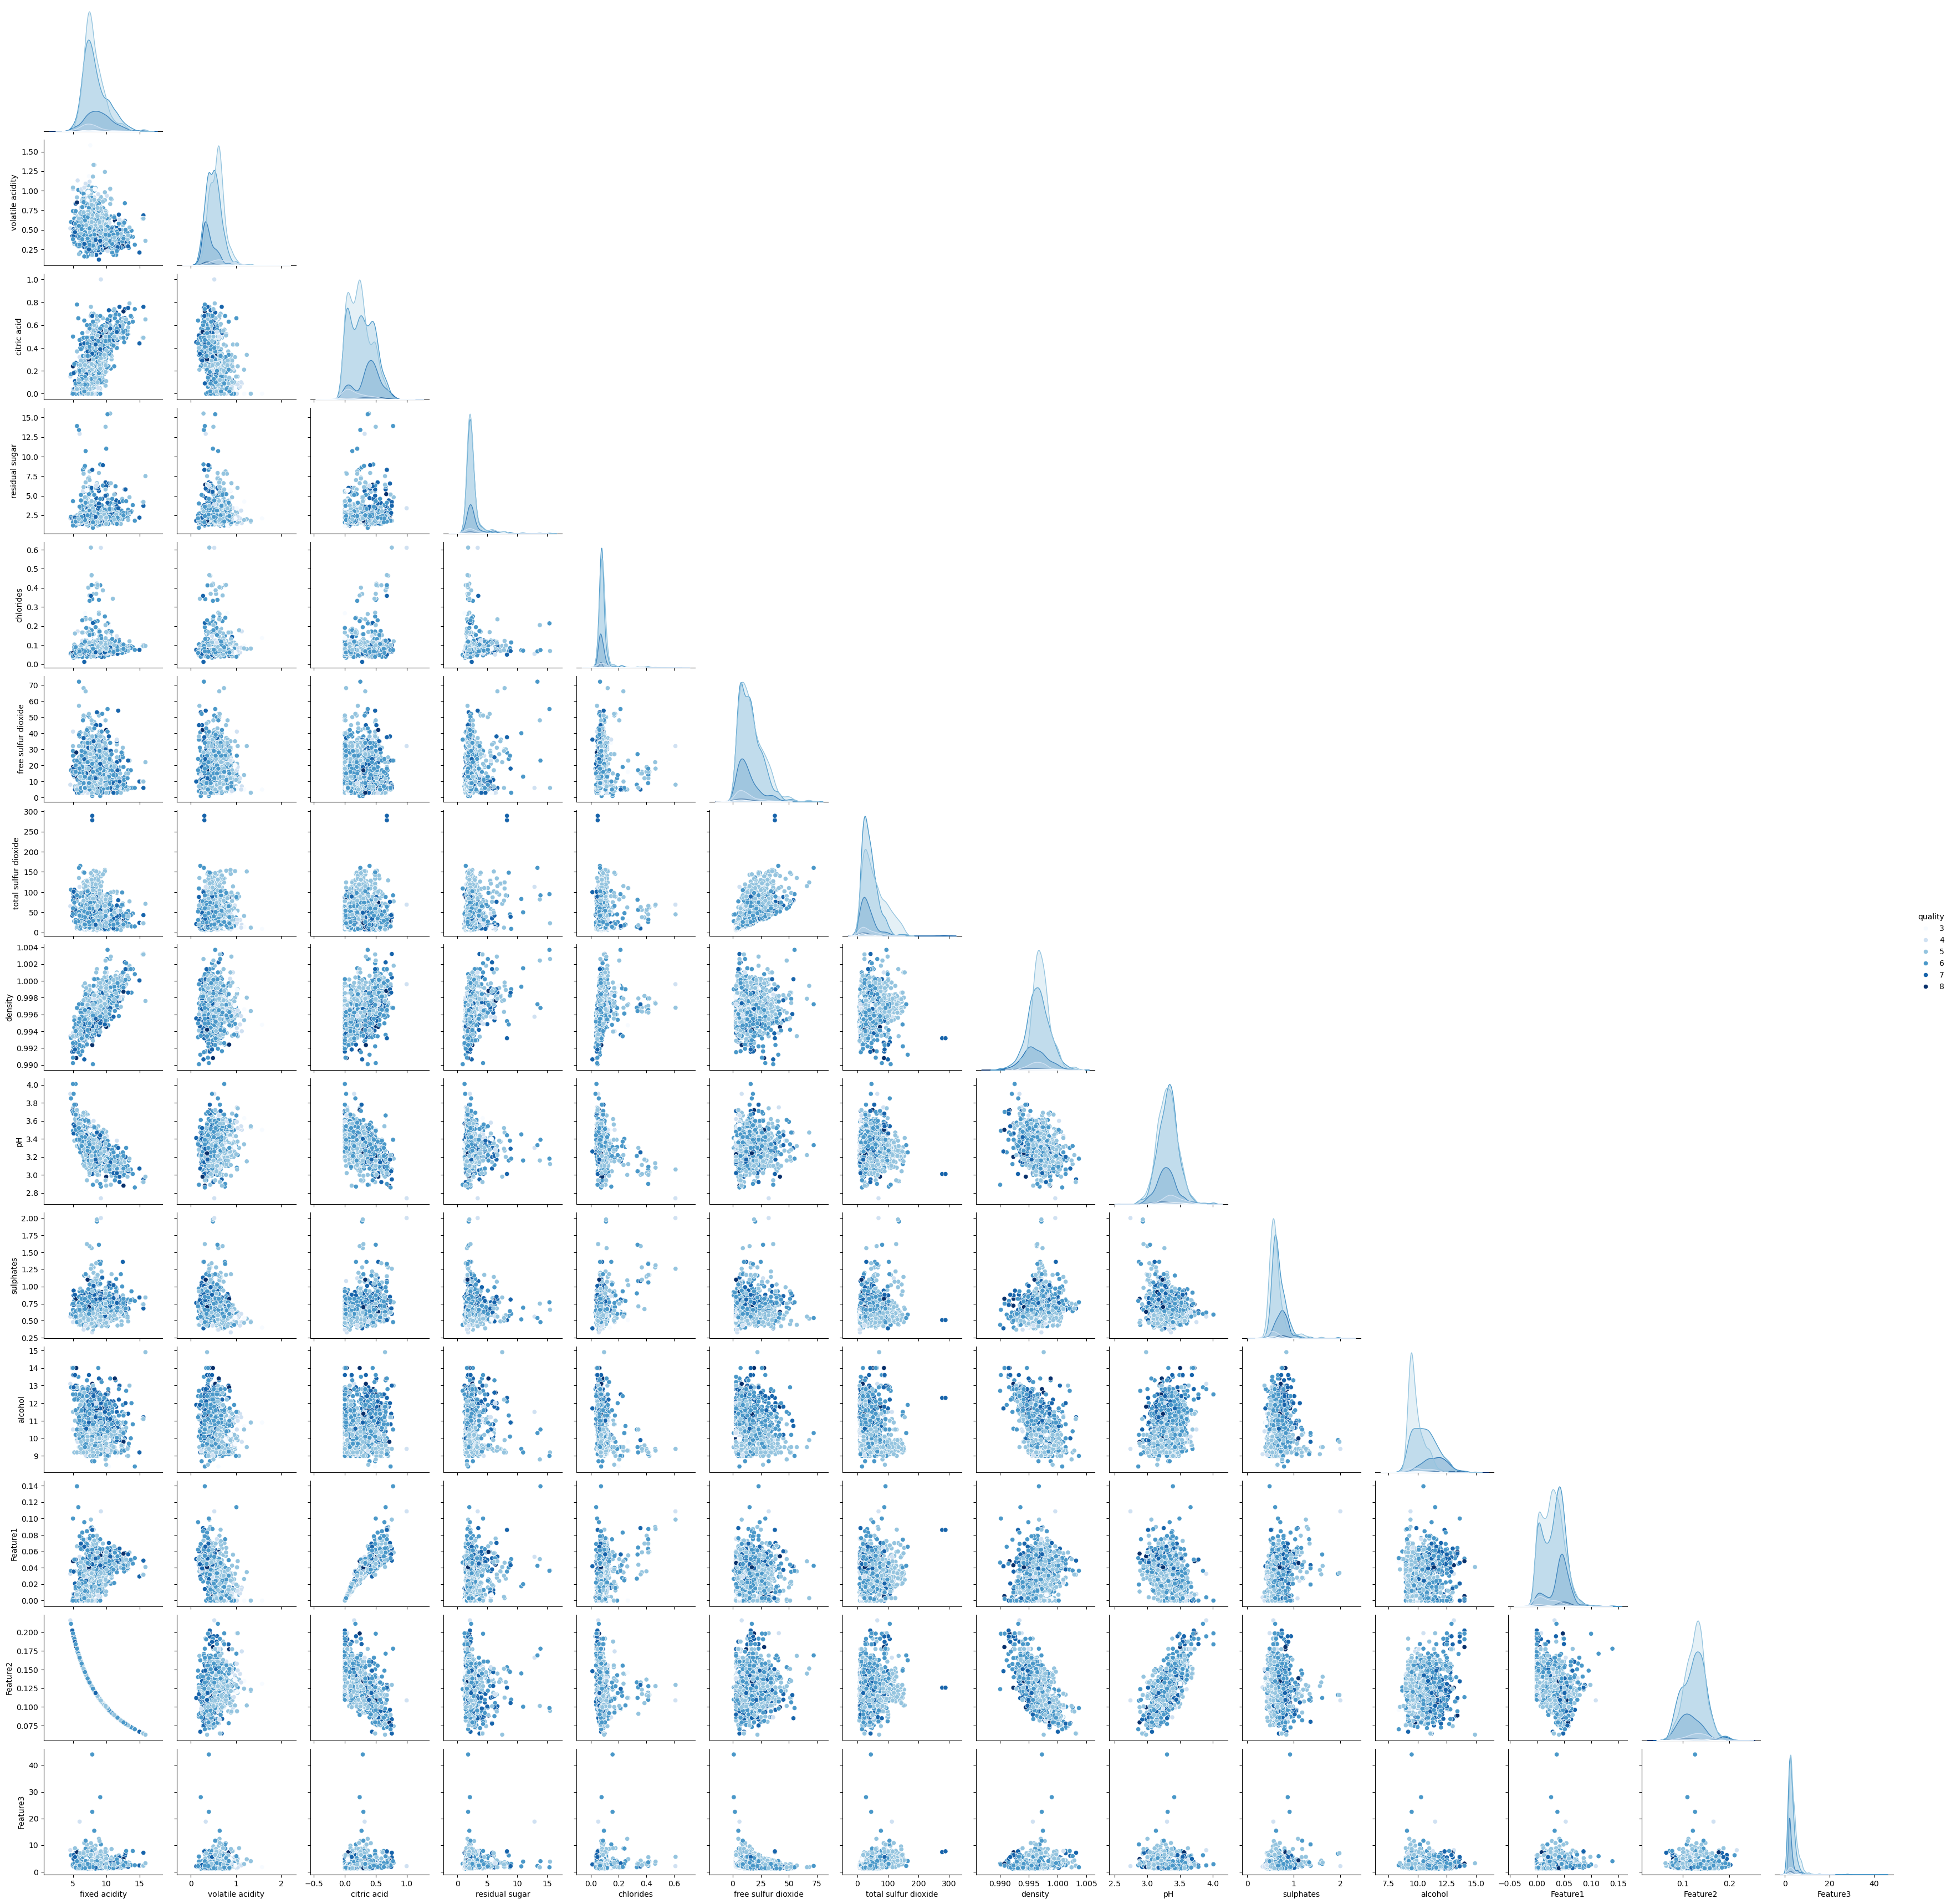

In [12]:
plt.figure(figsize=(18, 12))
sns.pairplot(wine_data, hue='quality', corner = True, palette='Blues')

In [15]:
X_safe = wine_data.drop(columns=['quality']) + 1e-5 # 加一个平滑项防止取log得0
y = wine_data['quality']
# 使用 Yeo-Johnson 方法进行变换，纠正偏度
pt = PowerTransformer(method='yeo-johnson')
X_norm = pd.DataFrame(
    pt.fit_transform(X_safe),
    columns=X_safe.columns
)

# 将quality列合并回去
wine_data_norm = pd.concat([X_norm, y.reset_index(drop=True)], axis=1)

<Figure size 1800x1200 with 0 Axes>

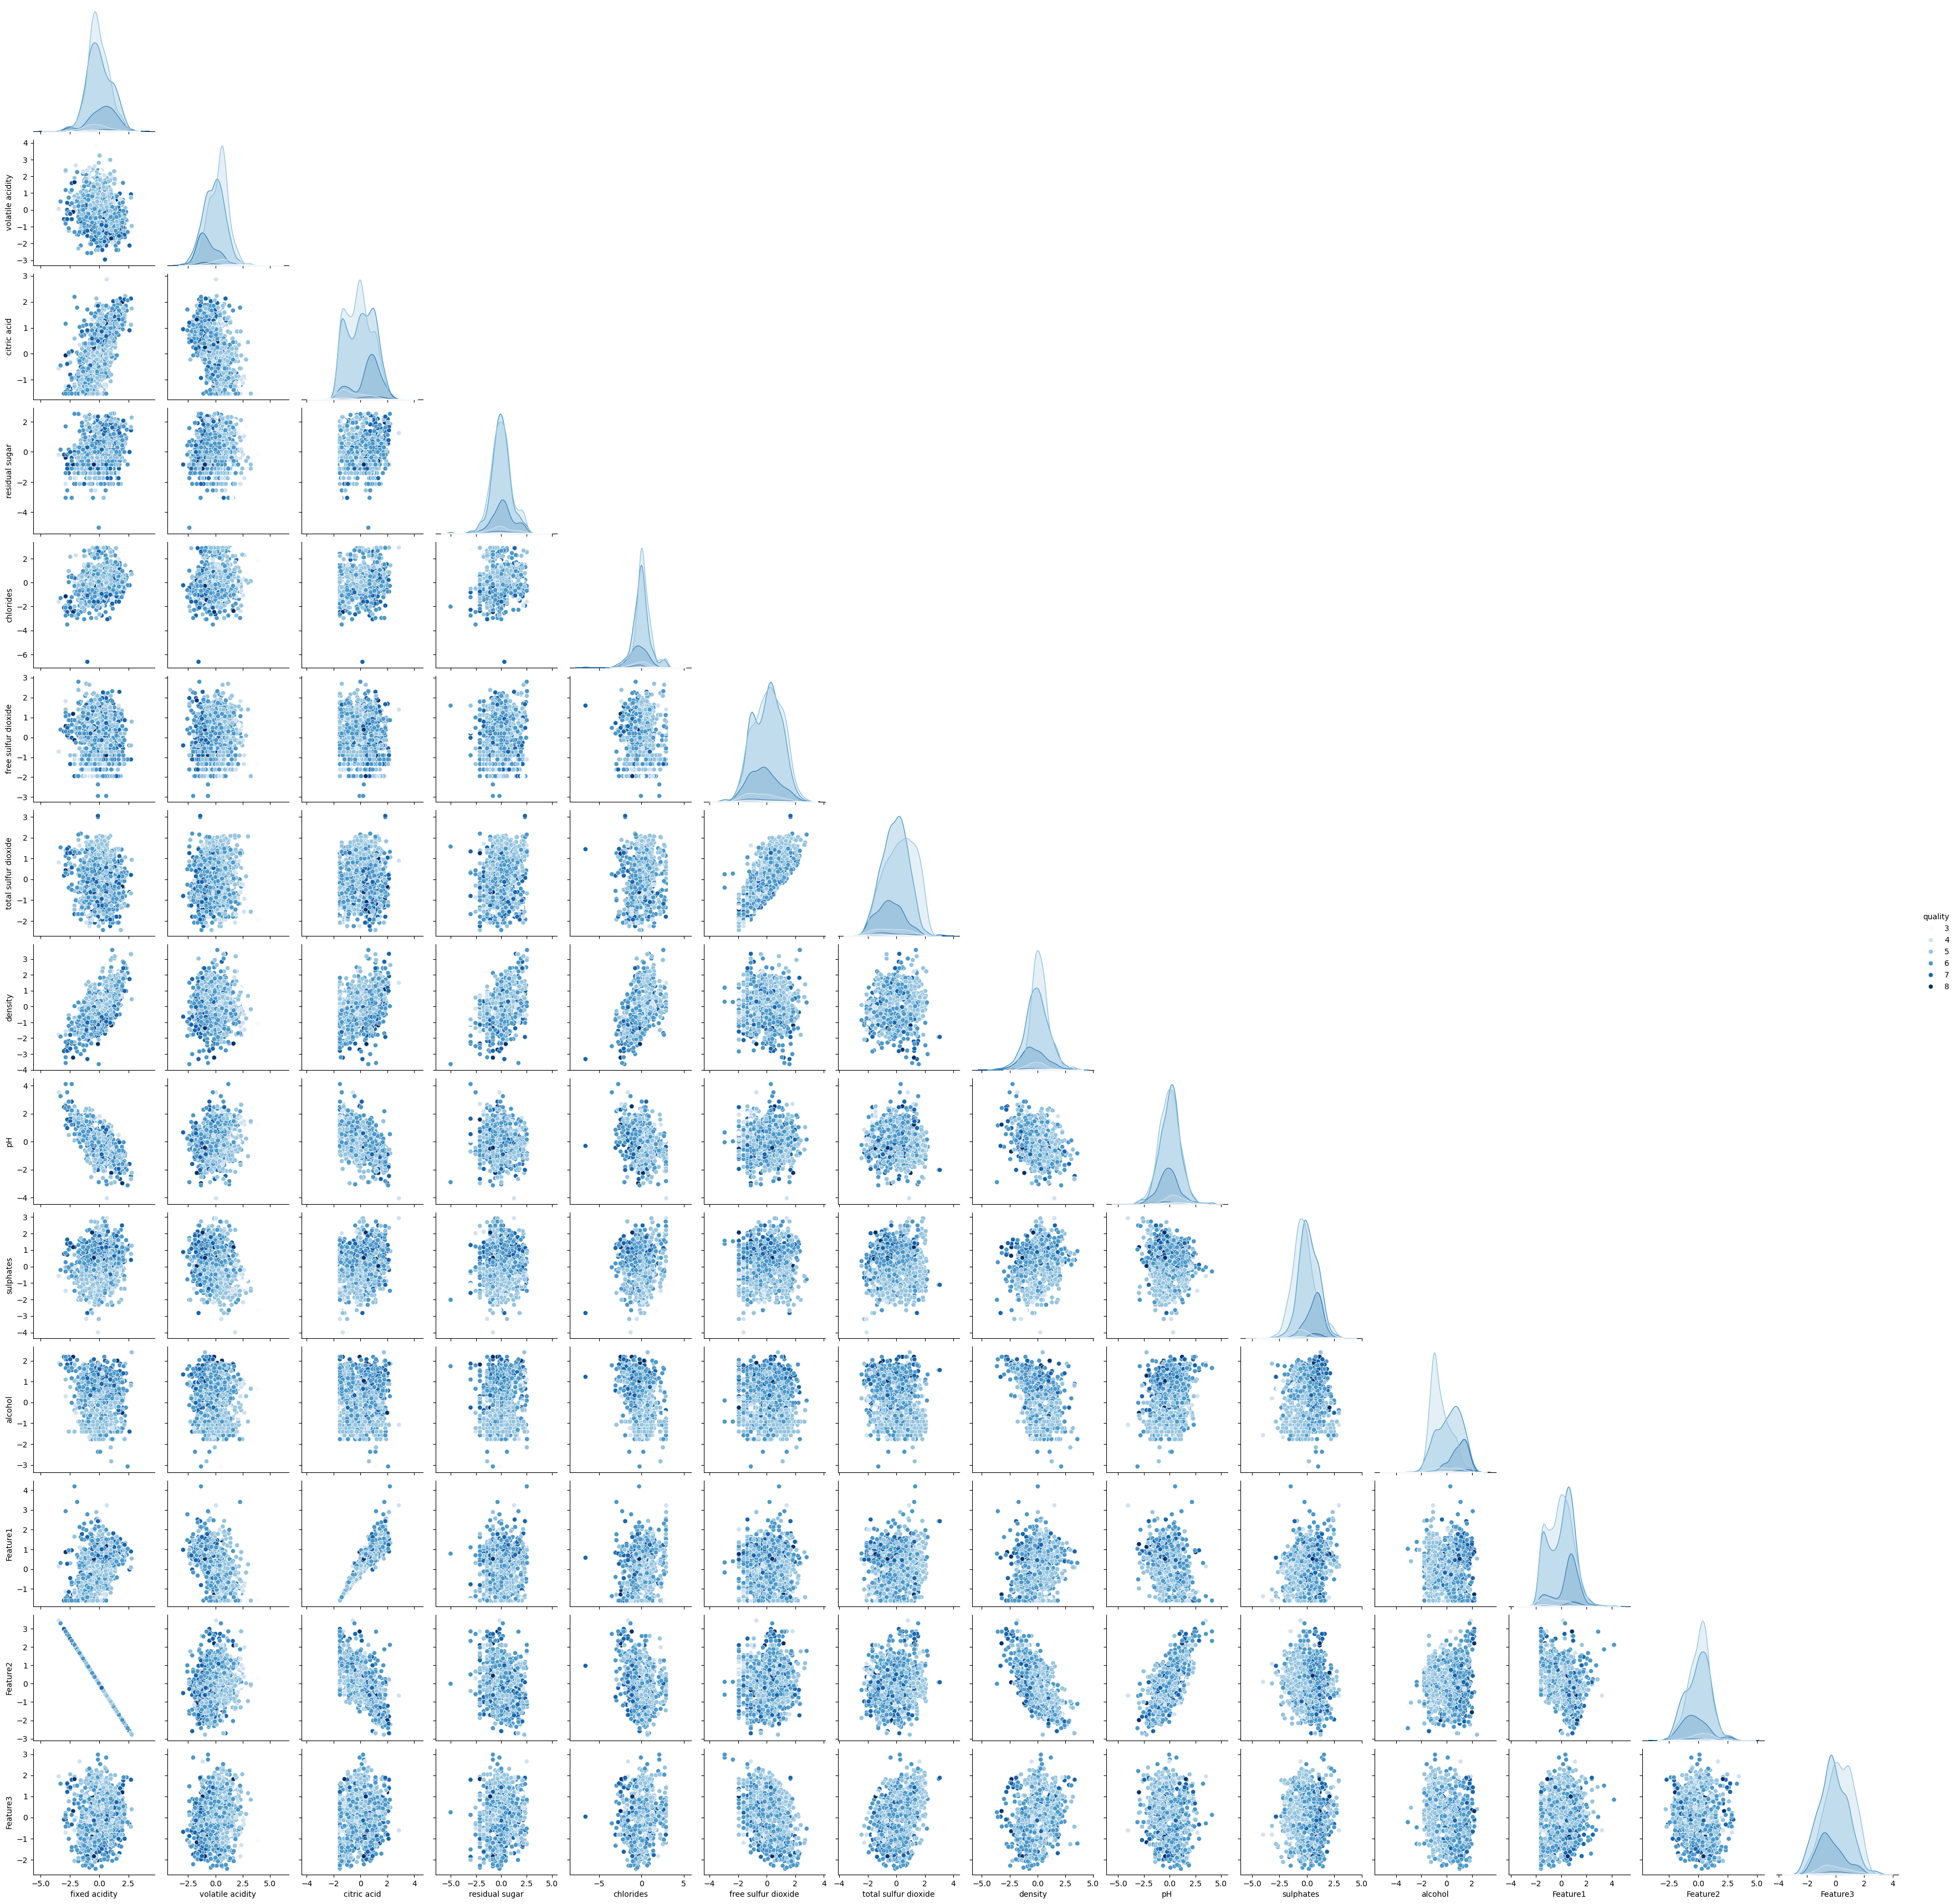

In [16]:
plt.figure(figsize=(18, 12))
sns.pairplot(wine_data_norm, hue='quality', corner = True, palette='Blues')

In [17]:
# 归一化
X = wine_data_norm.drop(['quality'], axis=1)
y = wine_data_norm['quality']

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

In [18]:
# 划分训练集和测试集(对y分层抽样)
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.3, random_state=42, stratify=y)

#### 2.建模与预测

**（1）随机森林（Random Forest）**

In [19]:
# Optuna调参
def rf_train(trial):
    clf = RandomForestClassifier(
        n_estimators=trial.suggest_int('n_estimators', 100, 500),
        max_depth=trial.suggest_int('max_depth', 5, 30),
        min_samples_split=trial.suggest_int('min_samples_split', 2, 10),
        min_samples_leaf=trial.suggest_int('min_samples_leaf', 1, 4),
        max_features=trial.suggest_categorical('max_features', ['sqrt', 'log2']),
        random_state=42
    )
    score = cross_val_score(clf, X_train, y_train, cv=5, scoring='accuracy')
    return score.mean()

study = optuna.create_study(direction="maximize")
study.optimize(rf_train, n_trials=20) # trial再增加也不能继续提高精度了

print("Best params:", study.best_params)

[I 2025-06-05 19:30:36,682] A new study created in memory with name: no-name-215e8618-d97b-482e-b99a-9203b51bf69b
[I 2025-06-05 19:30:42,679] Trial 0 finished with value: 0.6809457078795644 and parameters: {'n_estimators': 497, 'max_depth': 14, 'min_samples_split': 4, 'min_samples_leaf': 1, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6809457078795644.
[I 2025-06-05 19:30:44,987] Trial 1 finished with value: 0.67292200512492 and parameters: {'n_estimators': 208, 'max_depth': 19, 'min_samples_split': 2, 'min_samples_leaf': 3, 'max_features': 'sqrt'}. Best is trial 0 with value: 0.6809457078795644.
[I 2025-06-05 19:30:48,946] Trial 2 finished with value: 0.6827354260089686 and parameters: {'n_estimators': 342, 'max_depth': 28, 'min_samples_split': 6, 'min_samples_leaf': 2, 'max_features': 'log2'}. Best is trial 2 with value: 0.6827354260089686.
[I 2025-06-05 19:30:52,019] Trial 3 finished with value: 0.672009128763613 and parameters: {'n_estimators': 268, 'max_depth': 27, 'min_

Best params: {'n_estimators': 410, 'max_depth': 22, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'log2'}


准确率没有提升，且在加入特征工程后也没有提升，此模型不太好，后续将各模型对比

In [20]:
# 将最佳参数 unpack 给分类器
best_rf = RandomForestClassifier(**study.best_params, random_state=42)
best_rf.fit(X_train, y_train)

RandomForestClassifier(max_depth=22, max_features='log2', min_samples_leaf=2,
                       min_samples_split=5, n_estimators=410, random_state=42)

**（2）神经网络（Neural Network）**

In [21]:
# 转为 PyTorch Tensor
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train.to_numpy(), dtype=torch.long)

X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test.to_numpy(), dtype=torch.long)

In [22]:
# 构建 PyTorch Dataset
train_ds = TensorDataset(X_train_tensor, y_train_tensor)
test_ds = TensorDataset(X_test_tensor, y_test_tensor)

In [23]:
# 构建 DataLoader
train_loader = DataLoader(train_ds, batch_size=32, shuffle=True)
test_loader = DataLoader(test_ds, batch_size=32)

In [24]:
# 定义神经网络模型
class NNClassifier(nn.Module):
    def __init__(self):
        super(NNClassifier, self).__init__()
        self.fc1 = nn.Linear(14, 64)
        self.fc2 = nn.Linear(64, 32)
        self.out = nn.Linear(32, 11)  # 分类：11类

    def forward(self, x):
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        return F.log_softmax(self.out(x), dim=1)  # 做分类预测

model = NNClassifier()

In [25]:
# 定义优化器
criterion = nn.NLLLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [ ]:
# 加入 EarlyStopping 的训练模型
epochs = 300 # 最大训练轮数
patience = 5 # 容忍轮数
best_loss = float('inf') # 初始最小损失设为正无穷
trigger_times = 0 # 已触发轮数

for epoch in range(epochs):
    model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        optimizer.zero_grad() # 梯度清零
        outputs = model(X_batch) #前向传播计算预测值
        loss = criterion(outputs, y_batch) # 算出loss
        loss.backward() # 后向传播计算梯度
        optimizer.step() # 更新参数
        total_loss += loss.item()

    avg_loss = total_loss / len(train_loader)

    print(f"Epoch {epoch+1}/{epochs} - Avg Loss: {avg_loss:.4f}")

    # EarlyStopping 判断逻辑
    if avg_loss < best_loss - 1e-4:   # 只有显著变好才更新
        best_loss = avg_loss
        trigger_times = 0
    else:
        trigger_times += 1
        print(f"EarlyStopping counter: {trigger_times}/{patience}")
        if trigger_times >= patience:
            print(f"Early stopping triggered at epoch {epoch+1}!")
            break


Epoch 1/50 - Avg Loss: 0.2019
Epoch 2/50 - Avg Loss: 0.1980
Epoch 3/50 - Avg Loss: 0.1953
Epoch 4/50 - Avg Loss: 0.1924
Epoch 5/50 - Avg Loss: 0.1938
EarlyStopping counter: 1/5
Epoch 6/50 - Avg Loss: 0.1931
EarlyStopping counter: 2/5
Epoch 7/50 - Avg Loss: 0.1905
Epoch 8/50 - Avg Loss: 0.1879
Epoch 9/50 - Avg Loss: 0.1891
EarlyStopping counter: 1/5
Epoch 10/50 - Avg Loss: 0.1915
EarlyStopping counter: 2/5
Epoch 11/50 - Avg Loss: 0.1873
Epoch 12/50 - Avg Loss: 0.1789
Epoch 13/50 - Avg Loss: 0.1902
EarlyStopping counter: 1/5
Epoch 14/50 - Avg Loss: 0.1778
Epoch 15/50 - Avg Loss: 0.1791
EarlyStopping counter: 1/5
Epoch 16/50 - Avg Loss: 0.1717
Epoch 17/50 - Avg Loss: 0.1687
Epoch 18/50 - Avg Loss: 0.1716
EarlyStopping counter: 1/5
Epoch 19/50 - Avg Loss: 0.1768
EarlyStopping counter: 2/5
Epoch 20/50 - Avg Loss: 0.1761
EarlyStopping counter: 3/5
Epoch 21/50 - Avg Loss: 0.1686
EarlyStopping counter: 4/5
Epoch 22/50 - Avg Loss: 0.1707
EarlyStopping counter: 5/5
Early stopping triggered at ep

In [29]:
# 保存模型参数
torch.save(model.state_dict(), 'best_nn_model.pth')

**（3）支持向量机（Support Vector Machine, SVM）**

In [30]:
def svm_train(trial):
    kernel = trial.suggest_categorical("kernel", ["linear", "rbf", "poly"]) # 线性，高斯，多项式核
    C = trial.suggest_float("C", 0.1, 10.0, log=True) # 乘法系数

    if kernel in ["rbf", "poly"]:
        gamma = trial.suggest_float("gamma", 1e-4, 1.0, log=True)
    else:
        gamma = "scale" # 多项式不使用gamma，使用默认值

    if kernel == "poly":
        degree = trial.suggest_int("degree", 2, 5)
    else:
        degree = 3 #线性与高斯不适用degree，使用默认值
        
    svc_model = SVC(kernel=kernel, C=C, gamma=gamma, degree=degree)

    score = cross_val_score(svc_model, X_train, y_train, cv=5, scoring="accuracy")
    return score.mean()

In [31]:
study = optuna.create_study(direction="maximize")
study.optimize(svm_train, n_trials=50)

print("Best parameters:", study.best_params)

[I 2025-06-05 19:33:12,120] A new study created in memory with name: no-name-d110dbea-baa7-410f-91db-ebc80171b6f8
[I 2025-06-05 19:33:12,335] Trial 0 finished with value: 0.4861547085201794 and parameters: {'kernel': 'rbf', 'C': 0.2775511059584744, 'gamma': 0.0012058158223870572}. Best is trial 0 with value: 0.4861547085201794.
[I 2025-06-05 19:33:12,454] Trial 1 finished with value: 0.4262732222934017 and parameters: {'kernel': 'poly', 'C': 0.43638845035845714, 'gamma': 0.003881191551506542, 'degree': 5}. Best is trial 0 with value: 0.4861547085201794.
[I 2025-06-05 19:33:12,664] Trial 2 finished with value: 0.5862067584881486 and parameters: {'kernel': 'rbf', 'C': 8.825131325087096, 'gamma': 0.00040170184766975575}. Best is trial 2 with value: 0.5862067584881486.
[I 2025-06-05 19:33:13,029] Trial 3 finished with value: 0.5906630365150545 and parameters: {'kernel': 'linear', 'C': 2.343107917591772}. Best is trial 3 with value: 0.5906630365150545.
[I 2025-06-05 19:33:13,135] Trial 4 fi

Best parameters: {'kernel': 'rbf', 'C': 1.915341201424755, 'gamma': 0.43628834154329077}


In [32]:
best_svm = SVC(**study.best_params)
best_svm.fit(X_train, y_train)

SVC(C=1.915341201424755, gamma=0.43628834154329077)

#### 3.模型评价

由于11分类实际利用了回归模型，对预测值四舍五入

对于一个分类i：

* TP：真实值是i，预测值也被四舍五入为i

* FP：真实值不是i，预测值却被四舍五入为i

* FN：真实值是i，预测值却被四舍五入为非i

* TN：真实值不是i，预测值也不是i


In [33]:
def evaluate_model(name, model, X_test, y_test, is_regression=False):
    if name == "Neural Network":
        model.eval()
        with torch.no_grad():
            preds = model(torch.tensor(X_test, dtype=torch.float32))
            y_pred = preds.argmax(dim=1).numpy()
    else:
        y_pred = model.predict(X_test)
        
    print(f"\n=== {name} ===")
    print("Accuracy:", accuracy_score(y_test, y_pred))
    print("Precision:", precision_score(y_test, y_pred, average='macro', zero_division=0)) #zero_division对未出现过的类别精确率设置为0
    print("Recall:", recall_score(y_test, y_pred, average='macro', zero_division=0))
    print("F1-score:", f1_score(y_test, y_pred, average='macro', zero_division=0))
    print("\nClassification Report:")
    print(classification_report(y_test, y_pred, zero_division=0))

    # 混淆矩阵
    labels = list(range(11))
    cm = confusion_matrix(y_test, y_pred, labels=labels)
    
    plt.figure(figsize=(7, 5))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=labels, yticklabels=labels)
    plt.title(f"{name} - Confusion Matrix")
    plt.xlabel("Predicted Quality Score")
    plt.ylabel("True Quality Score")
    plt.show()


=== Random Forest ===
Accuracy: 0.6770833333333334
Precision: 0.3426778932293639
Recall: 0.31978145424836596
F1-score: 0.3232827703628573

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.72      0.78      0.75       204
           6       0.63      0.73      0.68       192
           7       0.71      0.40      0.51        60
           8       0.00      0.00      0.00         5

    accuracy                           0.68       480
   macro avg       0.34      0.32      0.32       480
weighted avg       0.65      0.68      0.65       480



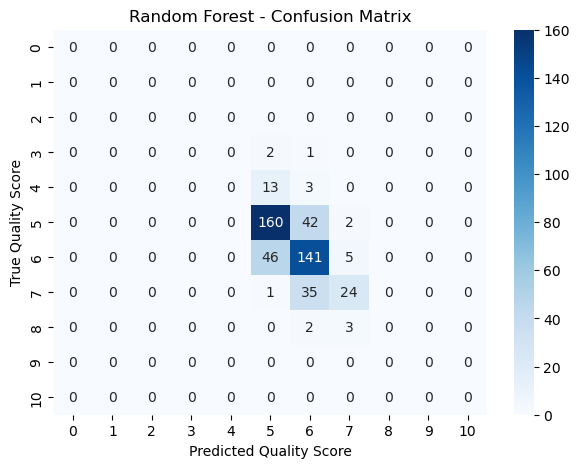


=== Neural Network ===
Accuracy: 0.6375
Precision: 0.36646735368037686
Recall: 0.34998978758169935
F1-score: 0.35624670671654485

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.69      0.70      0.70       204
           6       0.61      0.68      0.65       192
           7       0.65      0.52      0.57        60
           8       0.25      0.20      0.22         5

    accuracy                           0.64       480
   macro avg       0.37      0.35      0.36       480
weighted avg       0.62      0.64      0.63       480



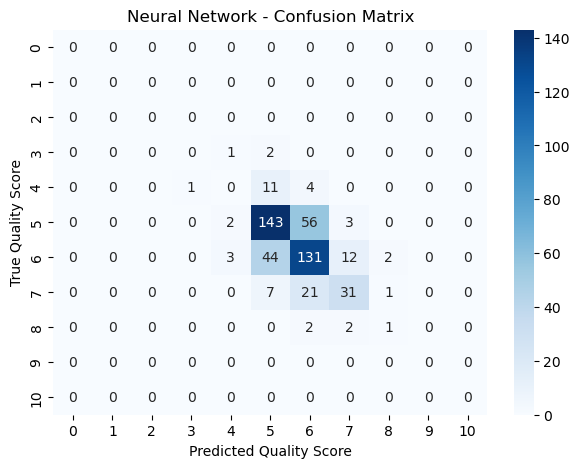


=== SVM ===
Accuracy: 0.6479166666666667
Precision: 0.425604047560834
Recall: 0.3402471405228758
F1-score: 0.3614492752903169

Classification Report:
              precision    recall  f1-score   support

           3       0.00      0.00      0.00         3
           4       0.00      0.00      0.00        16
           5       0.67      0.77      0.72       204
           6       0.61      0.67      0.64       192
           7       0.77      0.40      0.53        60
           8       0.50      0.20      0.29         5

    accuracy                           0.65       480
   macro avg       0.43      0.34      0.36       480
weighted avg       0.63      0.65      0.63       480



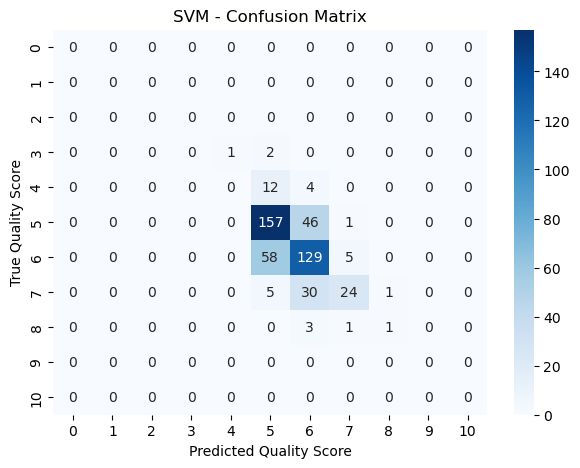

In [34]:
evaluate_model("Random Forest", best_rf, X_test, y_test)
evaluate_model("Neural Network", model, X_test, y_test, is_regression=True)
evaluate_model("SVM", best_svm, X_test, y_test)

#### 4.模型比较

**1.预测效果比较** 
| 模型          | Accuracy | Precision | Recall | F1-score |
| ----------- | -------- | --------- | ------ | -------- |
| 随机森林 (RF)   | 0.6771   | 0.4190    | 0.3525 | 0.3693   |
| 神经网络 (NN)   | 0.6083   | 0.2979    | 0.2996 | 0.2987   |
| 支持向量机 (SVM) | 0.6563   | 0.3653    |0.3525 | 0.3086   |

(1) Accuracy
* 随机森林accuracy最高，为 67.71%。
* SVM第二，为 65.63%。
* 神经网络第三，为 60.83%。
  
(2) Precision
* 随机森林precision最高，为 0.4190。
* SVM第二，为 0.3653。
* 神经网络第三，为 0.2979。
  
(3) Recall
* 随机森林recall最高，为 0.3525。
* SVM第二，为 0.3525。
* 神经网络第三，为 0.2996。
  
(4) F1-score
* 随机森林F1-score最高，为  0.3693。
* SVM第二，为 0.3086。
* 神经网络第三，为  0.2987。

从以上数据，本次训练模型效果为 随机森林 > SVM > 神经网络。

**2.预测细节分析**

(1) 混淆矩阵反映了什么样的数据分布
* 对于“5分”和“6分”这两个最常见的类别，三个模型都能取得较高的准确率。
* 对于其他类别，三个模型几乎都无法有效识别，precision/recall 均为 0。这主要因为这些类别样本太少，模型几乎未能学到有效特征。

(2) 宏平均：每一类内部取平均之后，按照类别个数加权平均。与普通加权平均不同之处在于，权重为类别数量而非类别内样本数量，能够更好反映对于全体类别的预测效果，而不是由占大部分的样本主导评估效果。

**3.参数优化**

* 对于随机森林和SVM，使用了Optuna进行参数优化，优化方式的核心为随机网格搜索；而神经网络使用内置的参数优化。

* 从epoch训练过程来看，神经网络在训练过程中能够实现连续的loss下降；而随机森林与SVM在使用Optuna寻找最优参数的过程中，搜索方向是随机的，没有连续的loss下降。

* 如果能够加深神经网络深度，设置合适的kernel，捕捉更多有用特征，神经网络将具有更大潜力。


**4.精确率提升方法**
* 对X做出正态化处理后，每个模型精确度都有所提升，提升幅度大约2%。 

**5.模型实用程度**

* 在这三个模型中，随机森林实用度最高。在有限复杂度下的分类问题，能够比神经网络和SVM取得更好效果，这是由于随机森林的运算增速小于神经网络，并且随机森林能比SVM这样的线性模型捕捉到更多特征，避免SVM造成的特征损失。